In [108]:
import glob
import pandas as pd
import json

projects = ["djanjo", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    filenames = glob.glob(f"../output/pytlint/{project}/*.json")
    for filename in filenames:
        with open(filename) as json_data:
            data = json.load(json_data)
            df = pd.json_normalize(data)
            df['project'] = project
            dfs.append(df)




In [109]:
df_py = pd.concat(dfs, ignore_index=True)

df_py.head(5)

,type,module,obj,line,column,endLine,endColumn,path,symbol,message,message-id,project
0,warning,flask.cli,FlaskGroup.list_commands,605,15,605,24,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
1,warning,flask.cli,run_command,898,11,898,20,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
2,warning,test_reqctx,test_teardown_with_previous_exception,39,11,39,20,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
3,warning,test_reqctx,test_teardown_with_handled_exception,58,15,58,24,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
4,warning,test_appctx,test_app_tearing_down_with_previous_exception,66,11,66,20,projects/py/flask/tests/test_appctx.py,broad-except,Catching too general exception Exception,W0703,flask


In [110]:
df_py.groupby(['project','message-id'])['message-id'].count()

project  message-id
flask    W0703           9
pandas   W0703          24
         W0706           2
         W0707          23
pytorch  E0702           5
         E0704           2
         W0702           4
         W0703         253
         W0706           6
         W0707           9
         W0715          11
Name: message-id, dtype: int64

In [111]:
import psycopg2

conn = psycopg2.connect("host={} user={} dbname=exception_miner password={} port={}".format("127.0.0.1", "exception_miner", "exception_miner", "5432"))
conn.set_session(autocommit=True)
cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS exceptions_pylint (type VARCHAR(255), module VARCHAR(255), obj VARCHAR(255), beginLine INT, beginColumn INT,	endLine INT, endColumn INT, path VARCHAR(255), symbol VARCHAR(255), message VARCHAR(255), message_id VARCHAR(255), project VARCHAR(255))""")

cur.execute("""DELETE FROM exceptions_pylint;""")

for i, row in df_py.iterrows():
    #print(row)
    cur.execute(("""INSERT INTO exceptions_pylint (type, module, obj, beginLine, beginColumn, endLine, endColumn, path, symbol, message, message_id, project)
                            VALUES (%s, %s, %s, %s, %s, %s,%s, %s, %s, %s, %s, %s  );"""), list(row))

OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


Python Parser

In [1]:
import glob
import pandas as pd
import json

# projects = ["django", "flask", "pytorch", "pandas"]
projects = ["flask"]
dfs=[]

for project in projects:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(f"../output/parser/{project}_stats.csv")
    df['project'] = project
    dfs.append(df)


In [2]:
df = pd.concat(dfs, ignore_index=True)
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
0,/home/r4ph/desenv/phd/exception-miner/projects...,loads,"def loads(self, value: str) -> t.Any:\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
1,/home/r4ph/desenv/phd/exception-miner/projects...,dumps,"def dumps(self, value: t.Any) -> str:\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
2,/home/r4ph/desenv/phd/exception-miner/projects...,untag,"def untag(self, value: dict[str, t.Any]) -> t....",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
3,/home/r4ph/desenv/phd/exception-miner/projects...,tag,"def tag(self, value: t.Any) -> dict[str, t.Any...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
4,/home/r4ph/desenv/phd/exception-miner/projects...,register,"def register(\n self,\n tag_clas...",0,0,0,0,1,0,0,0,0,0,NaN,KeyError,NaN,NaN,flask


In [3]:
df[df['str_uncaught_exceptions'].isnull() == False].shape

(5, 18)

In [4]:
df[df['n_try_except'] > 1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
259,/home/r4ph/desenv/phd/exception-miner/projects...,wsgi_app,"def wsgi_app(self, environ: dict, start_respon...",2,0,1,1,1,0,1,0,0,1,Exception,NaN,error = e\n response = self.han...,NaN,flask
329,/home/r4ph/desenv/phd/exception-miner/projects...,convert,"def convert(self, value, param, ctx):\n ...",3,0,0,0,3,0,1,0,0,1,ImportError click BadParameter ImportError Imp...,NaN,raise click.BadParameter(\n 'Us...,NaN,flask
336,/home/r4ph/desenv/phd/exception-miner/projects...,list_commands,"def list_commands(self, ctx):\n self._l...",2,0,0,1,0,0,0,0,0,0,NoAppException Exception,NaN,"click.secho(f""Error: {e.format_message()}\n"", ...",NaN,flask
353,/home/r4ph/desenv/phd/exception-miner/projects...,find_app_by_string,"def find_app_by_string(module, app_name):\n ...",4,0,0,0,8,0,0,0,0,0,SyntaxError ValueError AttributeError TypeError,NoAppException NoAppException NoAppException N...,"raise NoAppException(\n f""Failed to...",NaN,flask
819,/home/r4ph/desenv/phd/exception-miner/projects...,test_build_error_handler,def test_build_error_handler(app):\n # Test...,2,0,0,0,1,0,0,0,0,0,BuildError RuntimeError,RuntimeError,"error = err pytest.raises(BuildError, app.hand...",NaN,flask
898,/home/r4ph/desenv/phd/exception-miner/projects...,test_teardown_request_handler_error,"def test_teardown_request_handler_error(app, c...",2,2,0,2,2,0,0,0,0,0,Exception Exception,TypeError TypeError,pass pass,NaN,flask


In [5]:
df.shape

(1397, 18)

In [6]:
#TODO:
#Analisar Duplicados
df[df.duplicated()]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
21,/home/r4ph/desenv/phd/exception-miner/projects...,to_json,"def to_json(self, value: t.Any) -> t.Any:\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
153,/home/r4ph/desenv/phd/exception-miner/projects...,__exit__,"def __exit__(\n self,\n exc_type...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
491,/home/r4ph/desenv/phd/exception-miner/projects...,cli,def cli(**params):\n pass,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
496,/home/r4ph/desenv/phd/exception-miner/projects...,test,def test():\n click.echo(current_app.name),0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
516,/home/r4ph/desenv/phd/exception-miner/projects...,create_app,"def create_app():\n return Flask(""a...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,/home/r4ph/desenv/phd/exception-miner/projects...,add_language_code,"def add_language_code(endpoint, values):\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
1304,/home/r4ph/desenv/phd/exception-miner/projects...,index,"def index():\n return ""Hello World!""",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
1326,/home/r4ph/desenv/phd/exception-miner/projects...,index,"def index():\n return f""Hello {flask.re...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
1333,/home/r4ph/desenv/phd/exception-miner/projects...,end_of_request,def end_of_request(exception):\n buffer...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask


In [7]:
df = df.drop_duplicates().shape

Analyzing the Control Flow and Code

In [1]:
import glob
import pandas as pd
import json

projects = ["django", "flask", "pytorch", "pandas"]
dfs=[]
filenames = glob.glob(f"../output/parser/*.csv")

for filename in filenames:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(filename)
    project = filename.split("/")[-1].split("_")[0]
    df['project'] = project
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [2]:
df.project.unique()

array(['scikit-learn', 'ray', 'certbot', 'pyecharts', 'mmdetection',
       'sherlock', 'yapf', 'jax', 'requests', 'kivy', 'rasa', 'freqtrade',
       'django-rest-framework', 'aws-cli', 'ansible',
       'pytorch-image-models', 'faker', 'fastapi', 'kitty',
       'pytorch-lightning', 'scrapy', 'sqlmap', 'zipline', 'luigi',
       'pyspider', 'cookiecutter', 'redash', 'flask', 'black', 'jupyter',
       'streamlit', 'nginx-proxy', 'dalle-mini', 'tensor2tensor',
       'archivebox', 'fabric', 'mypy', 'ipython', 'autojump', 'bokeh',
       'magic-wormhole', 'dash', 'mackup', 'models', 'zulip', 'openpilot',
       'sanic', 'prophet', 'mkdocs', 'gensim', 'ungoogled-chromium',
       'keras', 'click', 'pytorch', 'horovod', 'youtube-dl', 'lightning',
       'fairseq', 'manim', 'tornado', 'algo', 'ghunt', 'rich', 'jina',
       'vit-pytorch', 'saleor', 'celery', 'loguru', 'tqdm', 'glances',
       'requests-html'], dtype=object)

In [3]:
len(df.project.unique())

71

In [4]:
df.shape

(312319, 18)

In [5]:
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
0,/home/r4ph/desenv/phd/exception-miner/projects...,close_issue_if_opened,"def close_issue_if_opened():\n print(""Test ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scikit-learn
1,/home/r4ph/desenv/phd/exception-miner/projects...,create_or_update_issue,"def create_or_update_issue(body=""""):\n # In...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scikit-learn
2,/home/r4ph/desenv/phd/exception-miner/projects...,get_issue,def get_issue():\n login = gh.get_user().lo...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scikit-learn
3,/home/r4ph/desenv/phd/exception-miner/projects...,entry_sort_key,"def entry_sort_key(s):\n if s.startswith(""-...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scikit-learn
4,/home/r4ph/desenv/phd/exception-miner/projects...,make_scorers,def make_scorers(self):\n make_gen_clas...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scikit-learn


In [6]:
df[df['str_except_identifiers'].notna()].head(10)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
125,/home/r4ph/desenv/phd/exception-miner/projects...,convertToFloat,"def convertToFloat(s, loc, toks):\r\n try:\...",1,0,0,0,1,0,0,0,0,1,BaseException e,ParseException,"raise ParseException(loc, ""invalid float forma...",NaN,scikit-learn
132,/home/r4ph/desenv/phd/exception-miner/projects...,cvt_fn,"def cvt_fn(s,l,t):\r\n try:\r\n ...",1,0,0,0,1,0,0,0,0,1,ValueError,ParseException,"raise ParseException(s, l, str(ve))",NaN,scikit-learn
133,/home/r4ph/desenv/phd/exception-miner/projects...,convertToDatetime,"def convertToDatetime(fmt=""%Y-%m-%dT%H:%M:%S.%...",1,0,0,0,1,0,0,0,0,1,ValueError,ParseException,"raise ParseException(s, l, str(ve))",NaN,scikit-learn
134,/home/r4ph/desenv/phd/exception-miner/projects...,cvt_fn,"def cvt_fn(s,l,t):\r\n try:\r\n ...",1,0,0,0,1,0,0,0,0,1,ValueError,ParseException,"raise ParseException(s, l, str(ve))",NaN,scikit-learn
135,/home/r4ph/desenv/phd/exception-miner/projects...,convertToDate,"def convertToDate(fmt=""%Y-%m-%d""):\r\n ...",1,0,0,0,1,0,0,0,0,1,ValueError,ParseException,"raise ParseException(s, l, str(ve))",NaN,scikit-learn
150,/home/r4ph/desenv/phd/exception-miner/projects...,tokenMap,"def tokenMap(func, *args):\r\n """"""\r\n H...",1,0,0,1,0,0,0,0,0,0,Exception,NaN,func_name = str(func),NaN,scikit-learn
155,/home/r4ph/desenv/phd/exception-miner/projects...,srange,"def srange(s):\r\n r""""""\r\n Helper to ea...",1,0,0,1,0,0,0,0,0,1,Exception,NaN,"return """"",NaN,scikit-learn
161,/home/r4ph/desenv/phd/exception-miner/projects...,oneOf,"def oneOf( strs, caseless=False, useRegex=True...",1,0,0,1,0,0,0,0,0,0,Exception,NaN,"warnings.warn(""Exception creating Regex for on...",NaN,scikit-learn
172,/home/r4ph/desenv/phd/exception-miner/projects...,z,def z(*paArgs):\r\n thisFunc = f.__name...,1,0,0,1,1,0,1,0,0,0,Exception,NaN,"sys.stderr.write( ""<<leaving %s (exception: %s...",NaN,scikit-learn
173,/home/r4ph/desenv/phd/exception-miner/projects...,traceParseAction,"def traceParseAction(f):\r\n """"""\r\n Dec...",2,1,0,1,1,0,1,0,0,0,Exception AttributeError,NaN,"sys.stderr.write( ""<<leaving %s (exception: %s...",NaN,scikit-learn


In [7]:
df.iloc[428,:].func_body

'def __getitem__( self, i ):\r\n        if isinstance( i, (int,slice) ):\r\n            return self.__toklist[i]\r\n        else:\r\n            if i not in self.__accumNames:\r\n                return self.__tokdict[i][-1][0]\r\n            else:\r\n                return ParseResults([ v[0] for v in self.__tokdict[i] ])'

In [8]:
df.iloc[428,:].str_except_identifiers

nan

In [9]:
df[df['n_finally'] > 1]#.count()

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
1767,/home/r4ph/desenv/phd/exception-miner/projects...,_sparse_encode_precomputed,"def _sparse_encode_precomputed(\n X,\n d...",0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scikit-learn
6378,/home/r4ph/desenv/phd/exception-miner/projects...,test_gradient_descent_stops,def test_gradient_descent_stops():\n # Test...,0,0,3,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scikit-learn
13833,/home/r4ph/desenv/phd/exception-miner/projects...,check_call_module,"def check_call_module(main, argv, capture_stdo...",2,0,2,1,2,0,0,0,0,0,SystemExit Exception,NaN,if ex.code:\n output = stream.buffe...,NaN,ray
24994,/home/r4ph/desenv/phd/exception-miner/projects...,run_api_experiment,"def run_api_experiment(input_features, output_...",0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,ray
29467,/home/r4ph/desenv/phd/exception-miner/projects...,test_drain_api,"def test_drain_api(shutdown_only):\n """"""E2E...",0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,ray
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307645,/home/r4ph/desenv/phd/exception-miner/projects...,test_process_initializer,"def test_process_initializer(self, _signals, s...",0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,celery
307757,/home/r4ph/desenv/phd/exception-miner/projects...,_chord_context,"def _chord_context(self, ResultCls, setup=None...",1,1,2,0,0,0,0,0,0,0,Retry,NaN,pass,NaN,celery
308117,/home/r4ph/desenv/phd/exception-miner/projects...,test_retry_not_eager,def test_retry_not_eager(self):\n self....,0,0,3,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,celery
308261,/home/r4ph/desenv/phd/exception-miner/projects...,test_apply_async_with_parent,def test_apply_async_with_parent(self):\n ...,0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,celery


In [10]:
df.iloc[500, :].func_body

'def parsed_args():\n    parser = argparse.ArgumentParser(\n        description=(\n            "Show commit message that triggered the build in Azure DevOps pipeline"\n        )\n    )\n    parser.add_argument(\n        "--only-show-message",\n        action="store_true",\n        default=False,\n        help=(\n            "Only print commit message. Useful for direct use in scripts rather than"\n            " setting output variable of the Azure job"\n        ),\n    )\n    return parser.parse_args()'

In [11]:
# from pandasql import sqldf

# q = """SELECT asd.project,
#        asd.n_functions,
#        asd.n_try_except,
#        ROUND((CAST(asd.n_try_except AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100                 as perc_trys_func,
#        asd.n_try_return,
#        ROUND((CAST(asd.n_try_return AS FLOAT) / CAST (asd.n_functions AS FLOAT)), 4) * 100  as perc_n_try_return,
#        asd.n_generic_except,
#        ROUND((CAST(asd.n_generic_except AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100            as perc_try_generic,
#        asd.n_try_pass,
#        ROUND((CAST(asd.n_try_pass AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100                  as perc_try_pass,
#        asd.n_try_else,
#        ROUND((CAST(asd.n_try_else AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_n_try_else,
#        asd.n_raise,
#        ROUND((CAST(asd.n_raise AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100 as perc_raise,
#        asd.n_captures_try_except_raise,
#        ROUND((CAST(asd.n_captures_try_except_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100 as perc_try_except_raise,
#        asd.n_captures_broad_raise,
#        ROUND((CAST(asd.n_captures_broad_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100      as perc_raise_broad,
#        asd.n_captures_misplaced_bare_raise,
#        ROUND((CAST(asd.n_captures_misplaced_bare_raise AS FLOAT) / CAST (asd.n_raise AS FLOAT)), 4) * 100  as perc_raise_mis_bare,
#        asd.n_finally,
#        ROUND((CAST(asd.n_finally AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_finally
# FROM (SELECT a.project,
#              COUNT(DISTINCT a.function)                n_functions,
#              SUM(a.n_try_except)                    as n_try_except,
#              SUM(a.n_generic_except)                as n_generic_except,
#              SUM(a.n_try_pass)                      as n_try_pass,
#              SUM(a.n_raise)                         as n_raise,
#              SUM(a.n_captures_try_except_raise)     as n_captures_try_except_raise,
#              SUM(a.n_captures_misplaced_bare_raise) as n_captures_misplaced_bare_raise,
#              SUM(a.n_captures_broad_raise)          as n_captures_broad_raise,
#              SUM(a.n_try_else)                      as n_try_else,
#              SUM(a.n_try_return)                    as n_try_return,
#              SUM(a.n_finally)                       as n_finally
#       FROM df a
#       GROUP BY a.project) asd;"""
# sqldf(q)



In [12]:
df[df['n_try_except'] >1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
173,/home/r4ph/desenv/phd/exception-miner/projects...,traceParseAction,"def traceParseAction(f):\r\n """"""\r\n Dec...",2,1,0,1,1,0,1,0,0,0,Exception AttributeError,NaN,"sys.stderr.write( ""<<leaving %s (exception: %s...",NaN,scikit-learn
196,/home/r4ph/desenv/phd/exception-miner/projects...,parseImpl,"def parseImpl( self, instring, loc, doActions=...",2,0,0,0,1,0,0,0,1,0,ParseBaseException ParseException IndexError,ParseException,break tmploc += 1,NaN,scikit-learn
229,/home/r4ph/desenv/phd/exception-miner/projects...,parseImpl,"def parseImpl( self, instring, loc, doActions=...",2,0,0,0,2,0,0,0,0,1,ParseException IndexError,maxException ParseException,if err.loc > maxExcLoc:\r\n ...,NaN,scikit-learn
234,/home/r4ph/desenv/phd/exception-miner/projects...,parseImpl,"def parseImpl( self, instring, loc, doActions=...",3,0,0,0,2,0,0,0,1,1,ParseException IndexError ParseException,maxException ParseException,err.__traceback__ = None\r\n if...,NaN,scikit-learn
239,/home/r4ph/desenv/phd/exception-miner/projects...,parseImpl,"def parseImpl( self, instring, loc, doActions=...",3,0,0,0,3,0,1,0,0,0,ParseSyntaxException ParseBaseException pe Ind...,ParseSyntaxException,raise pe.__traceback__ = None\r\n ...,NaN,scikit-learn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312026,/home/r4ph/desenv/phd/exception-miner/projects...,get_extended_stats,"def get_extended_stats(self, proc):\n ""...",4,1,0,0,0,0,0,0,1,0,psutil NoSuchProcess KeyError psutil AccessDen...,NaN,pass ret['memory_swap'] = None ret['tcp'] = No...,NaN,glances
312049,/home/r4ph/desenv/phd/exception-miner/projects...,__init__,"def __init__(self, cache_timeout=60):\n ...",2,0,0,2,0,0,0,0,2,0,Exception Exception,NaN,logger.warning('PsUtil can not grab processes ...,NaN,glances
312150,/home/r4ph/desenv/phd/exception-miner/projects...,update_glances,"def update_glances(self):\n """"""Get stat...",2,0,0,0,0,0,0,0,1,0,socket error Fault,NaN,"return ""Disconnected"" return ""Disconnected""",NaN,glances
312154,/home/r4ph/desenv/phd/exception-miner/projects...,_login_glances,"def _login_glances(self):\n """"""Login to...",2,0,0,0,0,0,0,0,0,0,socket error ProtocolError,NaN,self.client_mode = 'snmp'\n logger....,NaN,glances


In [13]:
df.str_except_block

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
312314    NaN
312315    NaN
312316    NaN
312317    NaN
312318    NaN
Name: str_except_block, Length: 312319, dtype: object

In [14]:
df.str_except_block.str.split(" ").explode().value_counts().reset_index().head(50)
#df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()
#df_raise_types = df_raise_types[1:]
#df_raise_types.head(20)

,index,str_except_block
0,,411525
1,=,6333
2,raise,5411
3,return,3282
4,to,2915
5,if,2624
6,pass,2464
7,not,1957
8,the,1771
9,in,1552


In [15]:
df.str_except_identifiers.unique()

array([nan, 'BaseException e', 'ValueError', ..., 'NameError KeyError',
       'socket error Fault', 'socket error ProtocolError'], dtype=object)

RQ1. How common and what are the main characteristics of exception handling practices in Python open-source projects?

In [16]:
cols = ['n_try_except', 'n_raise', 'n_finally', 'n_try_else']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [17]:
df_rq1 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] })
df_rq1 = df_rq1.max().to_frame().T

#df_rq1 = df.groupby('project').agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] }).reset_index()
#df_rq1.columns = list(map(''.join, df_rq1.columns.values))


In [67]:
cols = ['n_finally_uni', 'n_try_else_uni']

df_rq1['perc_n_try_except_uni'] = (df_rq1['n_try_except_uni']/ df_rq1['function']) * 100
df_rq1['perc_n_raise_uni'] = (df_rq1['n_raise_uni']/ df_rq1['function']) * 100

for col in cols:
     df_rq1['perc_'+col]= (df_rq1[col]/ df_rq1['n_try_except_uni']) * 100

df_rq1

,function,n_try_except_uni,n_raise_uni,n_finally_uni,n_try_else_uni,perc_n_try_except_uni,perc_n_raise_uni,perc_n_finally_uni,perc_n_try_else_uni
0,312316.0,12782.0,24773.0,2211.0,833.0,4.09265,7.93203,17.297762,6.516977


In [19]:
#df_rq1.loc[:, ["perc_n_try_except_unisum", "perc_n_raise_unisum", "perc_n_try_else_unisum", "perc_n_finally_unisum"]]

In [20]:
#df_total = df_rq1.agg({'perc_n_try_except_unisum': ['median', 'mean'], 'perc_n_raise_unisum': ['median', 'mean'], 'perc_n_try_else_unisum': ['median', 'mean'], 'perc_n_finally_unisum': ['median', 'mean']})
#df_total

In [68]:
df_total = df_rq1.loc[:, ["perc_n_try_except_uni", "perc_n_raise_uni", "perc_n_try_else_uni", "perc_n_finally_uni"]]

In [70]:
df_total.columns = ['try-except', 'raise', 'try-else', 'try-finally']
df_total

,try-except,raise,try-else,try-finally
0,4.09265,7.93203,6.516977,17.297762


In [71]:
df_total = df_total.T[0:].reset_index()
df_total

,index,0
0,try-except,4.092650
1,raise,7.932030
2,try-else,6.516977
3,try-finally,17.297762


In [72]:
#rename columns:
df_total.columns = ['Exception Handling', 'Percentage']
df_total['Percentage'] = df_total['Percentage'].round(2)


In [73]:
df_total = df_total.sort_values(by=['Percentage'], ascending=False)
df_total

,Exception Handling,Percentage
3,try-finally,17.30
1,raise,7.93
2,try-else,6.52
0,try-except,4.09


Boxplots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


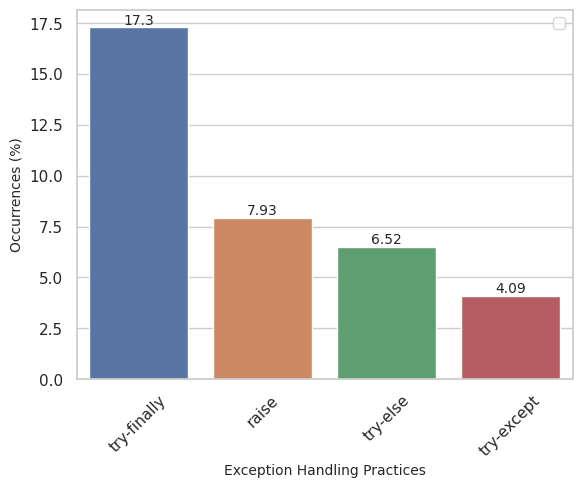

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total, x="Exception Handling", y="Percentage")
plt.ylabel("Occurrences (%)", fontsize= 10)
plt.xlabel("Exception Handling Practices", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)



In [27]:
df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()

In [28]:
df_except_types

,index,str_except_identifiers
0,Exception,3860
1,ValueError,1570
2,KeyError,1327
3,OSError,958
4,AttributeError,864
...,...,...
1301,FileAlreadyExists,1
1302,hive_metastore,1
1303,ttypes,1
1304,NoSuchObjectException,1


In [29]:
#df_except_types = df_except_types[1:]

In [30]:
def get_capitalized_elements(list):
    for element in list:
        if element[0].isupper():
            return element

In [31]:
#TODO: get a list of built-in exceptions and flag them
df_except_types['str_uniq_identifiers'] = df_except_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_except_types = df_except_types[df_except_types['str_uniq_identifiers'].notna()].head(20)

In [32]:
df_except_types = df_except_types.head(20) 
df_except_types['perc'] =  ((df_except_types['str_except_identifiers']/ df_except_types['str_except_identifiers'].sum()) * 100).round(2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


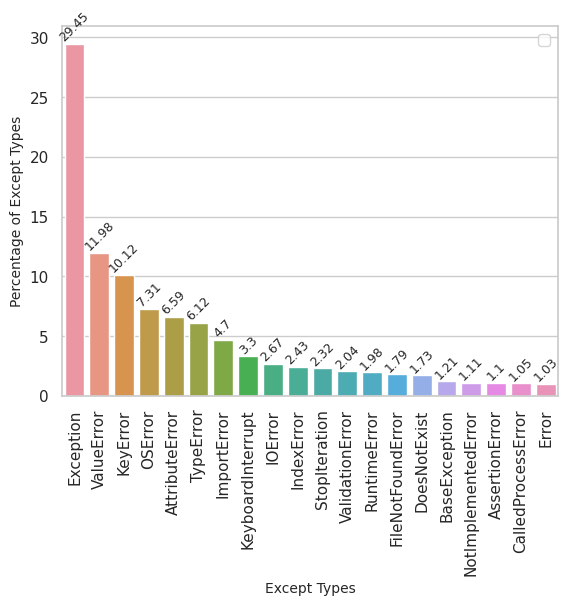

In [33]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_except_types, x="str_uniq_identifiers", y="perc")
plt.ylabel("Percentage of Except Types", fontsize= 10)
plt.xlabel("Except Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=9, rotation=45)


In [34]:
df_raise_types = df.str_raise_identifiers.str.split(" ").explode().value_counts().reset_index()
df_raise_types = df_raise_types[1:]
df_raise_types.head(20)

,index,str_raise_identifiers
1,NotImplementedError,2999
2,TypeError,1911
3,Exception,1881
4,RuntimeError,1832
5,SystemExit,959
6,ValidationError,722
7,AnsibleError,503
8,ExtractorError,490
9,AssertionError,481
10,JsonableError,474


In [35]:
df_raise_types['str_uniq_identifiers'] = df_raise_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_raise_types = df_raise_types[df_raise_types['str_uniq_identifiers'].notna()].head(20)

In [36]:
df_raise_types = df_raise_types.head(20) 
df_raise_types['perc'] =  ((df_raise_types['str_raise_identifiers']/ df_raise_types['str_raise_identifiers'].sum()) * 100).round(2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


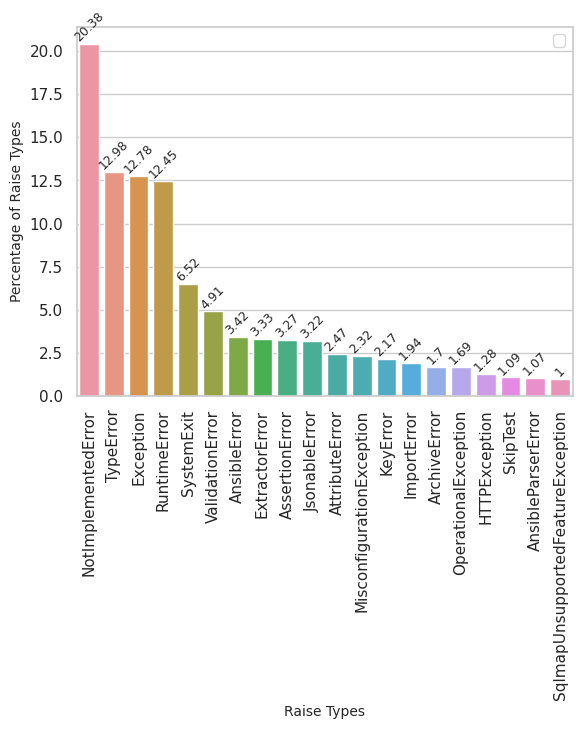

In [37]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_raise_types, x="index", y="perc")
plt.ylabel("Percentage of Raise Types", fontsize= 10)
plt.xlabel("Raise Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=9, rotation=45)

RQ2. 

In [38]:
df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.values

#df.str_uncaught_exceptions.str.split("[.][.][.]").values

array(['...setup.setup_package:RuntimeError',
       '...doc.tutorial.machine_learning_map.pyparsing.withAttribute:ParseException ...doc.tutorial.machine_learning_map.pyparsing.withAttribute:ParseException',
       '...sklearn.gaussian_process.kernels._check_length_scale:ValueError ...sklearn.gaussian_process.kernels._check_length_scale:ValueError ...sklearn.gaussian_process.kernels._check_length_scale:ValueError ...sklearn.gaussian_process.kernels._check_length_scale:ValueError',
       ..., '...tests.tests_tqdm.squash_ctrlchars:ValueError',
       '...tests.tests_tqdm.squash_ctrlchars:ValueError',
       '...tests.tests_tqdm.pos_line_diff:AssertionError'], dtype=object)

In [39]:
import numpy as np
#Couting uncaught exceptions:
#df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.str.split("[.][.][.]").values[3]

df['n_uncaught_exceptions'] = df['str_uncaught_exceptions'].str.split("[.][.][.]").apply(lambda x: len(x)-1 if x is not np.nan else 0)

In [40]:
cols = ['n_try_pass', 'n_generic_except', 'n_captures_try_except_raise', 'n_captures_broad_raise']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [41]:
df_rq2 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_try_pass_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_captures_try_except_raise_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_uncaught_exceptions': ['sum']})
df_rq2 = df_rq2.max().to_frame().T

In [42]:
df_rq2

,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,n_uncaught_exceptions
0,312316.0,12782.0,2073.0,3717.0,24773.0,841.0,1557.0,5479.0


In [43]:
#Trys
df_rq2['perc_n_try_pass_uni'] = (df_rq2['n_try_pass_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_generic_except_uni'] = (df_rq2['n_generic_except_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_uncaught_exceptions'] = (df_rq2['n_uncaught_exceptions']/ df_rq2['n_try_except_uni']) * 100

#Raise
df_rq2['perc_n_captures_try_except_raise_uni'] = (df_rq2['n_captures_try_except_raise_uni']/ df_rq2['n_raise_uni']) * 100
df_rq2['perc_n_captures_broad_raise_uni'] = (df_rq2['n_captures_broad_raise_uni']/ df_rq2['n_raise_uni']) * 100

df_rq2

,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,n_uncaught_exceptions,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni
0,312316.0,12782.0,2073.0,3717.0,24773.0,841.0,1557.0,5479.0,16.218119,29.079956,42.864966,3.394825,6.285068


In [44]:
df_total_rq2 = df_rq2.loc[:, ["perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_n_captures_try_except_raise_uni", "perc_n_captures_broad_raise_uni", "perc_uncaught_exceptions"]]
df_total_rq2

,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni,perc_uncaught_exceptions
0,16.218119,29.079956,3.394825,6.285068,42.864966


In [45]:
df_total_rq2.columns = ['CWE-1069', 'CWE-396', 'CWE-252', 'CWE-397', 'CWE-248']
df_total_rq2

,CWE-1069,CWE-396,CWE-252,CWE-397,CWE-248
0,16.218119,29.079956,3.394825,6.285068,42.864966


In [46]:
df_total_rq2 = df_total_rq2.T[0:].reset_index()
df_total_rq2

,index,0
0,CWE-1069,16.218119
1,CWE-396,29.079956
2,CWE-252,3.394825
3,CWE-397,6.285068
4,CWE-248,42.864966


In [47]:
#rename columns:
df_total_rq2.columns = ['Exception Handling', 'Percentage']
df_total_rq2['Percentage'] = df_total_rq2['Percentage'].round(2)

#order by percentage:
df_total_rq2 = df_total_rq2.sort_values(by=['Percentage'], ascending=False)
df_total_rq2

,Exception Handling,Percentage
4,CWE-248,42.86
1,CWE-396,29.08
0,CWE-1069,16.22
3,CWE-397,6.29
2,CWE-252,3.39


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


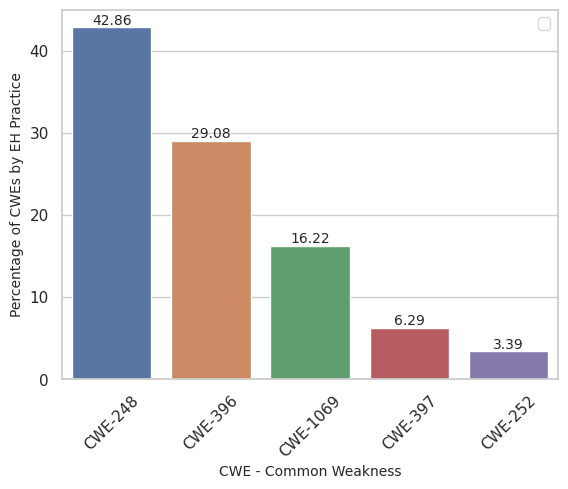

In [48]:
import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total_rq2, x="Exception Handling", y="Percentage")
plt.ylabel("Percentage of CWEs by EH Practice", fontsize= 10)
plt.xlabel("CWE - Common Weakness", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)

In [49]:
df_rq2_box = df[['project', 'function', 'n_try_except_uni', 'n_try_pass_uni', 'n_generic_except_uni', 'n_raise_uni', 'n_captures_try_except_raise_uni', 'n_captures_broad_raise_uni', 'n_uncaught_exceptions']]
df_rq2_box = df.groupby('project').agg( {'function': ['count'], 'n_try_except_uni': ['sum'], 'n_try_pass_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_captures_try_except_raise_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_uncaught_exceptions': ['sum']}).droplevel(1, axis=1).reset_index()

In [50]:
#Trys
df_rq2_box['perc_n_try_pass_uni'] = (df_rq2_box['n_try_pass_uni']/ df_rq2_box['n_try_except_uni']) * 100
df_rq2_box['perc_n_generic_except_uni'] = (df_rq2_box['n_generic_except_uni']/ df_rq2_box['n_try_except_uni']) * 100
df_rq2_box['perc_uncaught_exceptions'] = (df_rq2_box['n_uncaught_exceptions']/ df_rq2_box['n_try_except_uni']) * 100

#Raise
df_rq2_box['perc_n_captures_try_except_raise_uni'] = (df_rq2_box['n_captures_try_except_raise_uni']/ df_rq2_box['n_raise_uni']) * 100
df_rq2_box['perc_n_captures_broad_raise_uni'] = (df_rq2_box['n_captures_broad_raise_uni']/ df_rq2_box['n_raise_uni']) * 100

df_rq2_box

,project,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,n_uncaught_exceptions,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni
0,algo,46,12,0,5,0,0,0,0,0.000000,41.666667,0.000000,NaN,NaN
1,ansible,9754,1172,214,361,1283,80,140,518,18.259386,30.802048,44.197952,6.235386,10.911925
2,archivebox,9103,1174,278,587,1029,124,109,0,23.679727,50.000000,0.000000,12.050534,10.592809
3,autojump,215,16,2,0,20,1,0,0,12.500000,0.000000,0.000000,5.000000,0.000000
4,aws-cli,6364,170,12,35,317,4,7,43,7.058824,20.588235,25.294118,1.261830,2.208202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,vit-pytorch,625,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
67,yapf,1187,21,1,4,22,5,0,3,4.761905,19.047619,14.285714,22.727273,0.000000
68,youtube-dl,3750,251,33,30,519,78,6,25,13.147410,11.952191,9.960159,15.028902,1.156069
69,zipline,4440,194,29,13,514,12,9,8,14.948454,6.701031,4.123711,2.334630,1.750973


In [51]:
df_total_rq2_box = df_rq2_box.loc[:, ["perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_n_captures_try_except_raise_uni", "perc_n_captures_broad_raise_uni", "perc_uncaught_exceptions"]]
df_total_rq2_box

,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni,perc_uncaught_exceptions
0,0.000000,41.666667,NaN,NaN,0.000000
1,18.259386,30.802048,6.235386,10.911925,44.197952
2,23.679727,50.000000,12.050534,10.592809,0.000000
3,12.500000,0.000000,5.000000,0.000000,0.000000
4,7.058824,20.588235,1.261830,2.208202,25.294118
...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN
67,4.761905,19.047619,22.727273,0.000000,14.285714
68,13.147410,11.952191,15.028902,1.156069,9.960159
69,14.948454,6.701031,2.334630,1.750973,4.123711


In [52]:
df_total_rq2_box.columns = ['CWE-391', 'CWE-396', 'CWE-252', 'CWE-397', 'CWE-248']
df_total_rq2_box

,CWE-391,CWE-396,CWE-252,CWE-397,CWE-248
0,0.000000,41.666667,NaN,NaN,0.000000
1,18.259386,30.802048,6.235386,10.911925,44.197952
2,23.679727,50.000000,12.050534,10.592809,0.000000
3,12.500000,0.000000,5.000000,0.000000,0.000000
4,7.058824,20.588235,1.261830,2.208202,25.294118
...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN
67,4.761905,19.047619,22.727273,0.000000,14.285714
68,13.147410,11.952191,15.028902,1.156069,9.960159
69,14.948454,6.701031,2.334630,1.750973,4.123711


In [53]:
#df_total_rq2 = df_total_rq2_box.T[0:].reset_index()
df_total_rq2_box.T[0:].reset_index()

,index,0,1,2,3,4,5,6,7,8,...,61,62,63,64,65,66,67,68,69,70
0,CWE-391,0.000000,18.259386,23.679727,12.5,7.058824,21.212121,14.285714,25.988701,8.695652,...,16.883117,10.389610,19.306931,25.000000,17.241379,NaN,4.761905,13.147410,14.948454,9.815951
1,CWE-396,41.666667,30.802048,50.000000,0.0,20.588235,15.151515,24.338624,16.572505,6.521739,...,37.012987,2.597403,32.673267,31.250000,0.000000,NaN,19.047619,11.952191,6.701031,11.451943
2,CWE-252,NaN,6.235386,12.050534,5.0,1.261830,2.857143,0.516796,3.193277,4.738155,...,2.834008,0.000000,7.758621,13.953488,0.000000,NaN,22.727273,15.028902,2.334630,2.647413
3,CWE-397,NaN,10.911925,10.592809,0.0,2.208202,0.000000,0.000000,2.016807,1.995012,...,4.858300,1.732673,16.666667,0.000000,0.000000,NaN,0.000000,1.156069,1.750973,5.655836
4,CWE-248,0.000000,44.197952,0.000000,0.0,25.294118,51.515152,55.555556,8.474576,8.695652,...,82.467532,0.000000,0.000000,20.312500,189.655172,NaN,14.285714,9.960159,4.123711,87.525562
